In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import json
import os
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit
from math import sqrt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler 
import gurobipy as gb
from gurobipy import GRB
import math as math

In [ ]:

DataX = pd.read_csv("Feature_selected.csv",index_col=0)
DataY = pd.read_csv("Processed_data.csv")['Actual']
X_train, X_test, y_train, y_test = train_test_split(DataX, DataY, test_size=0.25, shuffle = False)

prices_df = pd.read_csv("Prices_processed.csv",index_col =0).round(2)
prices_train, prices_test = train_test_split(prices_df, test_size=0.25, shuffle = False)

# Polynomial non-linear Regression

In [ ]:
# Using polynomial features to make non-linear regression models with multiple degrees.
degree = [2,3,4,5]
# Empty matrix to store the predictions for each degree
preds_poly_matrix = np.zeros((len(y_test), len(degree)))
for d in degree:
    # Creating the polynomial feature function
    poly = PolynomialFeatures(degree=d,interaction_only=False)
    # Transforming the X data sets using the polynomial created
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    reg = LinearRegression().fit(X_train_poly, y_train)
    preds = reg.predict(X_test_poly)
    
    preds_poly_matrix[:, d - 2] = reg.predict(X_test_poly)

    #check error 
    print('MSE dgree {0}:'.format(d),np.round(mean_squared_error(y_test, preds), decimals=4))
    print('RMSE dgree {0}'.format(d),np.round(math.sqrt(mean_squared_error(y_test, preds)), decimals=4))
    print('R^2 dgree {0}:'.format(d),np.round(r2_score(y_test, preds, force_finite=False), decimals=4))
    print('MAE dgree {0}:'.format(d),np.round(mean_absolute_error(y_test, preds), decimals=4))
    #print('Score:',reg.score(X_train, y_train))


MSE dgree 2: 0.0075
RMSE dgree 2 0.0868
R^2 dgree 2: 0.7484
MAE dgree 2: 0.0677
MSE dgree 3: 0.007
RMSE dgree 3 0.0837
R^2 dgree 3: 0.7663
MAE dgree 3: 0.0637
MSE dgree 4: 0.0074
RMSE dgree 4 0.0862
R^2 dgree 4: 0.752
MAE dgree 4: 0.0644
MSE dgree 5: 0.0177
RMSE dgree 5 0.1331
R^2 dgree 5: 0.4094
MAE dgree 5: 0.0817


# Weighted Regression

In [ ]:
# WARNING: THIS MODEL RUNS FOR around 1 HOUR
# Weighted regression using the guassian matrix with only the most 2 important feautures
X_train, X_test, y_train, y_test = train_test_split(DataX[['max_wind_speed_3sec','mean_pressure']],DataY, test_size=0.25, shuffle = False)

X_train = X_train.to_numpy().reshape(-1, X_train.shape[1])
X_test = X_test.to_numpy().reshape(-1, X_test.shape[1])

# Guassian kernel
def gaussian(t):
    # Where t = ||x_0 - x||_2
    return np.exp(-0.5 * t**2) / np.sqrt(2 * np.pi) 

radius = 0.4
y_pred_wls = np.zeros(len(X_test))
# Weighted regression algorithm
for i in range(len(X_test)):
    W = np.diagflat(gaussian(np.linalg.norm(X_train - X_test[i], axis=1) / radius))
    theta = np.linalg.inv(X_train.T @ W @ X_train) @ X_train.T @ W @ y_train
    y_pred_wls[i] = X_test[i] @ theta

# Storing the predictions in a csv file to avoid having to rerun the model
y_w_preds = pd.DataFrame(y_pred_wls,columns = ['Preds'])
y_w_preds.to_csv('Weighted Predicitions.csv')

y_pred_wls = pd.read_csv("Weighted Predicitions.csv")['Preds'].to_numpy()

#check error 
print('MSE:',np.round(mean_squared_error(y_test, y_pred_wls), decimals=4))
print('RMSE',np.round(math.sqrt(mean_squared_error(y_test, y_pred_wls)), decimals=4))
print('R^2',np.round(r2_score(y_test, y_pred_wls, force_finite=False), decimals=4))
print('MAE:',np.round(mean_absolute_error(y_test, y_pred_wls), decimals=4))
#print('Score:',reg.score(X_train, y_train))

MSE: 0.0114
RMSE 0.1069
R^2 0.619
MAE: 0.0841


# Plots

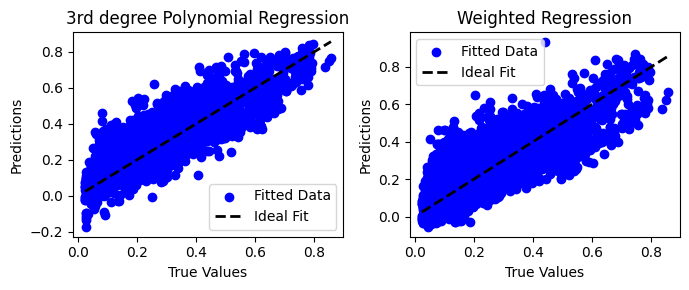

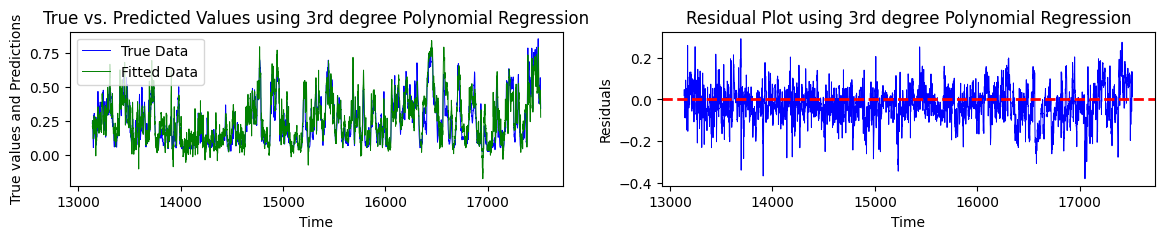

Under predicting: -188.88016377287408
Over predicting: 90.25299148125019


In [ ]:
preds_poly = preds_poly_matrix[:,1]

plt.figure(figsize=(7, 3))
# Subplot 1
# Plotting the true values vs the fitted values for the 3rd degree polynomial regression
plt.subplot(121)  # 1 row, 2 columns, plot 1
plt.scatter(y_test, preds_poly , c='b', label='Fitted Data')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2, label='Ideal Fit')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('3rd degree Polynomial Regression')
plt.legend()

# Subplot 2
# Plotting the true values vs the fitted values for the weighted regression
plt.subplot(122)  # 1 row, 2 columns, plot 1
plt.scatter(y_test, y_pred_wls, c='b', label='Fitted Data')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2, label='Ideal Fit')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Weighted Regression')
plt.legend()

plt.tight_layout()
plt.show()

# Plotting the true values and fitted values on the time series axis for the 3rd degree polynomial regression
plt.figure(figsize=(14, 2)) 
plt.subplot(121)
plt.plot(y_test.index, y_test, alpha = 1,lw=0.7, c='b', label='True Data')
plt.plot(y_test.index, preds_poly , alpha = 1,lw=0.7, c='g', label='Fitted Data')
plt.xlabel('Time')
plt.ylabel('True values and Predictions')
plt.title('True vs. Predicted Values using 3rd degree Polynomial Regression')
plt.legend()

residuals = y_test - preds_poly 

# Plotting the residual values on the time series axis for the 3rd degree polynomial regression
plt.subplot(122)
plt.plot(y_test.index , residuals,lw=0.7, c='b')
plt.axhline(0, color='r', linestyle='--', lw=2)
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.title('Residual Plot using 3rd degree Polynomial Regression')

plt.show()

print('Under predicting:',sum(residuals[residuals<0]))
print('Over predicting:',sum(residuals[residuals>0]))



# Revenue Calculations

In [ ]:
def Optimization_wind(Windspeed,prices):
    #Windspeed = Windspeed.to_numpy()
    Time = len(Windspeed)
    T = range(Time)

    DA_prices = prices["SpotPriceEUR"].to_numpy()
    Up_prices = prices["Up-regulating_price"].to_numpy()
    Down_prices = prices["Down-regulating_price"].to_numpy()
    Capacity = 1 

    psi_up= Up_prices -DA_prices
    psi_down = DA_prices- Down_prices

    model_opt = gb.Model("Step1_A")
    p_DA_A = model_opt.addVars(Time,lb=0)
    p_delt = model_opt.addVars(Time,lb=-gb.GRB.INFINITY,ub=gb.GRB.INFINITY)

    p_E_up = model_opt.addVars(Time,lb =-1,ub=0)
    p_E_down = model_opt.addVars(Time,lb =0,ub=1)

    model_opt.setObjective(
    gb.quicksum(p_DA_A[t]*DA_prices[t] 
            + (Up_prices[t] *  p_E_up[t] + Down_prices[t] *  p_E_down[t]) for t in T )
            ,gb.GRB.MAXIMIZE)

    
    model_opt.addConstrs(
    (p_DA_A[t] <= Capacity
    for t in T
    )
    )

    model_opt.addConstrs(
    (
    p_delt[t] == Windspeed[t]-p_DA_A[t]
    for t in T
    )
    )

    model_opt.addConstrs(
    (
    p_delt[t] == p_E_up[t] + p_E_down[t]
    for t in T
    )
    )

    model_opt.setParam('OutputFlag', False )
    model_opt.optimize()
    if model_opt.status == GRB.OPTIMAL:
        obj_val =  model_opt.objVal 
        print("Revenue =", "{:.2f}".format(model_opt.objVal))
        print("Offering Strategy =", ["{:.2f}".format(p_DA_A[t].x) for t in T])
        print("Imbalance Power =", ["{:.2f}".format(p_delt[t].x) for t in T])
        print("Real Power  =", ["{:.2f}".format(Windspeed[t]) for t in T])
        P_DA = [p_DA_A[t].x for t in T]
        obj_vals_hour ={t: p_DA_A[t].x*DA_prices[t] - (Up_prices[t] *  p_E_up[t].x + Down_prices[t] *  p_E_down[t].x) for t in T }

        p_E_up_list =[p_E_up[t].x for t in T]
        p_E_down_list = [p_E_down[t].x for t in T]


    else:
        print("Optimization was not successful")

    return P_DA,obj_val,obj_vals_hour,p_E_up_list,p_E_down_list

In [ ]:
def balancing_revenue(P_DA_bid, real_wind, prices):
    """
    Inputs: 
    P_DA_bid = The Day ahead bids that have been made by optimization program at time t 
    real_wind = The actual power produced by wind turbine at time t         
    prices = The prices time 


    Calculates the result of our day ahead bids based on our wind forecast 

    Outputs: 
    Revenue: The actual revenue by our prediction of day ahead bids
    p_up: The upregulation power needed to be provided
    p_down: The downregulation power able to provided 

    """
    Time = len(P_DA_bid)
    T = range(Time)
    real_wind = real_wind.values
    DA_prices = prices["SpotPriceEUR"].to_numpy()
    Up_prices = prices["Up-regulating_price"].to_numpy()
    Down_prices = prices["Down-regulating_price"].to_numpy()
    p_up = np.empty(Time)
    p_down = np.empty(Time)
 
    for t in T:
        
        
        if real_wind[t] <= P_DA_bid[t] :
            p_up[t] = real_wind[t] -P_DA_bid[t]
        else:
            p_up[t] = 0
        if real_wind[t] >= P_DA_bid[t] :
            p_down[t] = real_wind[t] - P_DA_bid[t]
        else:
            p_down[t] = 0
    
    Revenue = np.dot(P_DA_bid,DA_prices) + np.dot(p_up,Up_prices) + np.dot(p_down,Down_prices)   
    
    return Revenue, p_up,p_down


In [ ]:
DataY_vals = preds_poly
# Change values to be between 0 and 1 at min and max
DataY_vals[DataY_vals<0] =0
DataY_vals[DataY_vals>1] =1
M1_P_DA_vals,M1_obj_val, M1_obj_vals_hour,M1_p_E_up_list,M1_p_E_down_list = Optimization_wind(DataY_vals,prices_test)
M1_Revenue, M1_p_up, M1_p_down = balancing_revenue(M1_P_DA_vals, y_test, prices_test)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-07


Revenue = 531117.71
Offering Strategy = ['1.00', '0.21', '1.00', '0.25', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '0.28', '0.16', '0.17', '0.28', '0.16', '1.00', '0.00', '0.16', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '0.00', '1.00', '0.24', '0.00', '0.00', '0.24', '0.20', '0.00', '0.30', '0.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '0.41', '0.41', '0.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '0.00', '0.00', '0.28', '0.24', '0.19', '0.17', '0.15', '0.21', '1.00', '0.25', '0.27', '0.34', '0.25',

In [ ]:
M1_Revenue

500775.11517828464

In [ ]:
DataY_vals = y_pred_wls
# Change values to be between 0 and 1 at min and max
DataY_vals[DataY_vals<0] =0
DataY_vals[DataY_vals>1] =1
M2_P_DA_vals,M2_obj_val, M2_obj_vals_hour,M2_p_E_up_list,M2_p_E_down_list = Optimization_wind(DataY_vals,prices_test)
M2_Revenue, M2_p_up, M2_p_down = balancing_revenue(M2_P_DA_vals, y_test, prices_test)

Revenue = 539509.00
Offering Strategy = ['1.00', '0.38', '1.00', '0.40', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '0.34', '0.33', '0.33', '0.41', '0.29', '1.00', '0.00', '0.32', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '0.00', '1.00', '0.41', '0.00', '0.00', '0.37', '0.37', '0.00', '0.45', '0.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '0.48', '0.43', '0.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '0.00', '0.00', '0.25', '0.23', '0.18', '0.16', '0.14', '0.23', '1.00', '0.32', '0.35', '0.35', '1.00',

In [ ]:
M2_Revenue

500125.1653316724

In [ ]:
# Storing in csv files to avoid having to rerun the code

# Opt_out = pd.DataFrame()

# Opt_out["M1_P_DA_vals"] = M1_P_DA_vals
# Opt_out["M1_obj_val"] = M1_P_DA_vals
# Opt_out["M1_obj_vals_hour"] = M1_obj_vals_hour
# Opt_out["M1_p_E_up_list"] = M1_p_E_up_list
# Opt_out["M1_p_E_down_list"] = M1_p_E_down_list

# Opt_out["M1_Revenue"] = M1_Revenue
# Opt_out["M1_p_up"] = M1_p_up
# Opt_out["M1_p_down"] = M1_p_down

# Opt_out["M2_P_DA_vals"] = M2_P_DA_vals
# Opt_out["M2_obj_val"] = M2_P_DA_vals
# Opt_out["M2_obj_vals_hour"] = M2_obj_vals_hour
# Opt_out["M2_p_E_up_list"] = M2_p_E_up_list
# Opt_out["M2_p_E_down_list"] = M2_p_E_down_list

# Opt_out["M2_Revenue"] = M2_Revenue
# Opt_out["M2_p_up"] = M2_p_up
# Opt_out["M2_p_down"] = M2_p_down

# Opt_out.to_csv('non-LR Opt Output.csv')

# preds_LR = pd.DataFrame()
# preds_LR['preds_poly'] = preds_poly_matrix[:,1]
# preds_LR['y_pred_wls'] = y_pred_wls
# preds_LR.to_csv('non LR preds.csv')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=538942fa-4593-4d1a-b90d-2d23669fe78c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>